In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.utils import shuffle
from PIL import Image
import torchvision.transforms.v2 as v2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.isotonic import IsotonicRegression

import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Read images (pad to square, resize)

In [ ]:
IMAGE_FOLDER = '/content/drive/MyDrive/project/masked_images'

In [ ]:
def pad_image_to_square(image):
    """
    Pads the input image to make it square. The padding is done with black (0, 0, 0) pixels.

    Args:
    - image: The input image (numpy array) read using OpenCV.

    Returns:
    - Padded image (numpy array) in square shape.
    """
    # Get the current dimensions of the image
    height, width, channels = image.shape

    # Determine the size of the padded square image
    max_dim = max(width, height)

    # Calculate padding for each side (left, right, top, bottom)
    padding_top = (max_dim - height) // 2
    padding_bottom = max_dim - height - padding_top
    padding_left = (max_dim - width) // 2
    padding_right = max_dim - width - padding_left

    # Pad the image with black (0, 0, 0) background
    padded_image = cv2.copyMakeBorder(image, padding_top, padding_bottom, padding_left, padding_right,
                                       borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    return padded_image

In [ ]:
def load_images_and_labels(image_folder, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            # Get the full path to the image
            image_path = os.path.join(image_folder, filename)

            # Read the image using OpenCV
            image = cv2.imread(image_path)

            # Extract the label (floating point number at the end of the filename)
            label_str = filename.split('_')[-1]  # e.g. "s132.66"
            label = float(label_str[1:-4])  # Convert "132.66" into float

            # padd the image before resizing
            image = pad_image_to_square(image)

            # resize the image
            image = cv2.resize(image, target_size)

            # Append the image and label to their respective arrays
            images.append(image)
            labels.append(label)

    # Convert lists to numpy arrays
    #images = np.array(images)
    #labels = np.array(labels)

    return images, labels

In [ ]:
images, labels = load_images_and_labels(IMAGE_FOLDER)

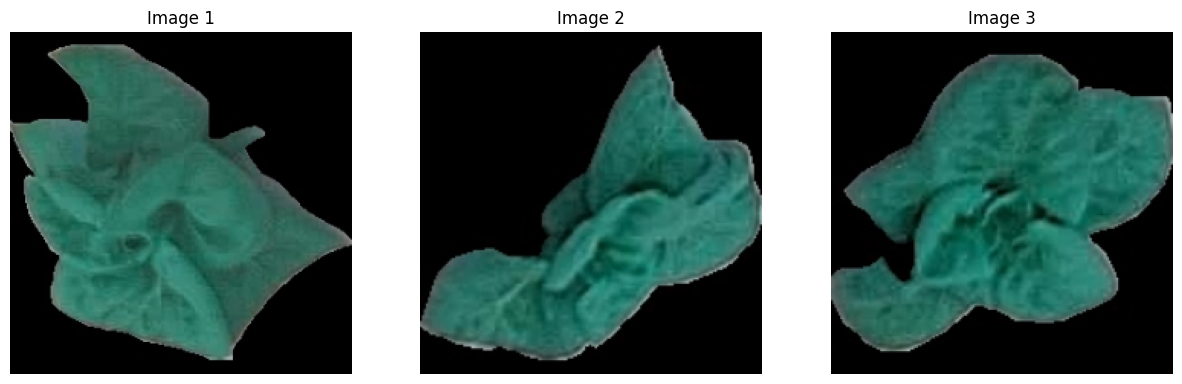

In [ ]:
plt.figure(figsize=(15, 5))  # Set figure size for better display
for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, plot each image
    plt.imshow(images[i])
    plt.title(f"Image {i+1}")
    plt.axis('off')  # Turn off axes for better image visualization

plt.show()

In [ ]:
print(labels[:3])

[119.42, 87.08, 84.46]


In [ ]:
images[45].shape

(224, 224, 3)

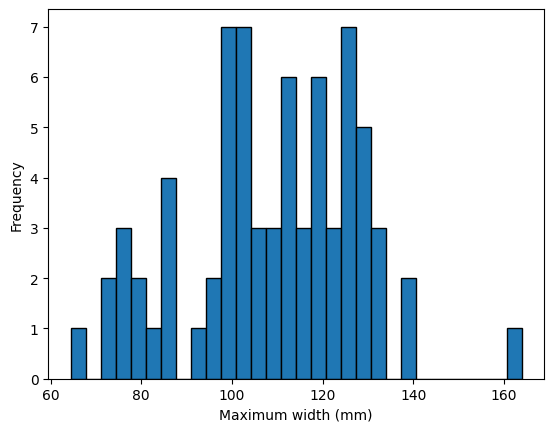

In [ ]:
# Plot histogram
plt.hist(labels, bins=30, edgecolor='black')

# Add titles and labels
#plt.title('Histogram of Random Values')
plt.xlabel('Maximum width (mm)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
np.max(np.array(labels))

163.9

# Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Apply augmentation to train set

In [ ]:
type(x_train[0])

numpy.ndarray

In [ ]:
x_train_augmented = []
y_train_augmented = []

# Define the perspective transformation
perspective_transformer = v2.RandomPerspective(distortion_scale=0.2, p=1.0)

for image, label in zip(x_train, y_train):
    image = Image.fromarray(image.astype(np.uint8))

    augmented_images = [perspective_transformer(image) for _ in range(5)]
    augmented_labels = [label]*5

    x_train_augmented.append(image)
    x_train_augmented.extend(augmented_images)

    y_train_augmented.append(label)
    y_train_augmented.extend(augmented_labels)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the image data generator for data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,       # Random rotation between -20 to 20 degrees
#     width_shift_range=0.1,   # Random horizontal shift
#     height_shift_range=0.1,  # Random vertical shift
#     shear_range=0.1,         # Shearing transformation
#     zoom_range=0.1,          # Zoom in and out
#     horizontal_flip=True,    # Randomly flip images horizontally
#     fill_mode='nearest'      # Fill in missing pixels after rotation or shift
# )

# # Apply augmentation only to training data
# x_train_augmented = []
# y_train_augmented = []

# for x, y in zip(x_train, y_train):
#     x_train_augmented.append(image)
#     y_train_augmented.append(label)
#     # Reshape x to (1, height, width, channels) to fit the generator's expected input
#     x = x.reshape((1, *x.shape))
#     # Generate a batch of augmented images
#     augmented_images = datagen.flow(x, batch_size=1)
#     for i in range(5):  # Generate 5 augmented versions of each image
#         augmented_image = augmented_images[0][0]
#         x_train_augmented.append(augmented_image)
#         y_train_augmented.append(y)

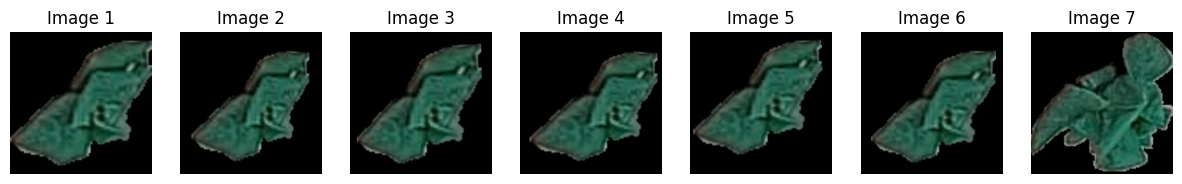

In [ ]:
def show_images(image_array, num_images=7):
    """Displays the first `num_images` from `image_array` using matplotlib."""
    plt.figure(figsize=(15, 5))  # Set figure size

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)  # Create subplots in a row
        plt.imshow(image_array[i])  # Show image
        plt.axis("off")  # Hide axis
        plt.title(f"Image {i+1}")  # Title

    plt.show()  # Display all images

# Example usage
show_images(x_train_augmented)

# Normalize images

In [ ]:
x_train = np.array([(img_to_array(image) / 255.0) for image in x_train_augmented])
x_test = np.array([(img_to_array(image) / 255.0) for image in x_test])
y_train = np.array(y_train_augmented)
y_test = np.array(y_test)

x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
type(x_train)

numpy.ndarray

# Feature extraction

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x_train.shape

(342, 224, 224, 3)

In [ ]:
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


# Define prototypical model

In [ ]:
class FewShotModel(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(FewShotModel, self).__init__()
        self.embedding_layer = layers.Dense(embedding_dim, activation='relu')
        self.regression_head = layers.Dense(1)  # Regression for leaf length prediction

    def call(self, inputs):
        embeddings = self.embedding_layer(inputs)
        leaf_length_pred = self.regression_head(embeddings)
        return leaf_length_pred

In [ ]:
# class FewShotModel(tf.keras.Model):
#     def __init__(self, embedding_dim_1, embedding_dim_2):
#         super(FewShotModel, self).__init__()
#         self.embedding_layer_1 = layers.Dense(embedding_dim_1, activation='relu')
#         self.embedding_layer_2 = layers.Dense(embedding_dim_2, activation='relu')
#         self.regression_head = layers.Dense(1)  # Regression for leaf length prediction

#     def call(self, inputs):
#         embeddings_1 = self.embedding_layer_1(inputs)
#         embeddings_2 = self.embedding_layer_2(embeddings_1)
#         leaf_length_pred = self.regression_head(embeddings_2)
#         return leaf_length_pred

# Instantiate and compile model

In [ ]:
embedding_dim = 64
model = FewShotModel(embedding_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
# embedding_dim_1 = 512
# embedding_dim_2 = 64
# model = FewShotModel(embedding_dim_1, embedding_dim_2)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

# Train model

In [ ]:
history = model.fit(train_features, y_train, epochs=160, batch_size=8, validation_data=(test_features, y_test))

Epoch 1/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 10075.7070 - val_loss: 4904.5845
Epoch 2/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3431.4717 - val_loss: 735.6799
Epoch 3/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 457.4874 - val_loss: 335.5207
Epoch 4/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 350.4802 - val_loss: 337.9770
Epoch 5/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 335.6736 - val_loss: 335.8843
Epoch 6/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 381.3097 - val_loss: 344.1584
Epoch 7/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 348.4784 - val_loss: 333.4236
Epoch 8/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 335.4165 - val_loss: 332.7329
Epoch 9/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 340.0566 - val_loss: 331.8647
Epoch 10/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 336.1017 - val_loss: 335.8534
Epoch 11/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 344.3954 - val_loss: 330.3676
Epoch 12/160

# Evaluation

In [ ]:
test_loss = model.evaluate(test_features, y_test)
print(f"Test Loss (MSE): {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 220.8976
Test Loss (MSE): 220.8976287841797


In [ ]:
# Example prediction on test set
predictions = model.predict(test_features)
for i, pred in enumerate(predictions[:5]):  # Print first 5 predictions as an example
    print(f"Predicted Leaf Length: {pred[0]:.2f}, Actual Leaf Length: {y_test[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Leaf Length: 113.67, Actual Leaf Length: 126.92
Predicted Leaf Length: 96.46, Actual Leaf Length: 117.94
Predicted Leaf Length: 91.31, Actual Leaf Length: 71.56
Predicted Leaf Length: 124.72, Actual Leaf Length: 119.42
Predicted Leaf Length: 118.13, Actual Leaf Length: 110.68


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

R² Score: 0.33049335090173815


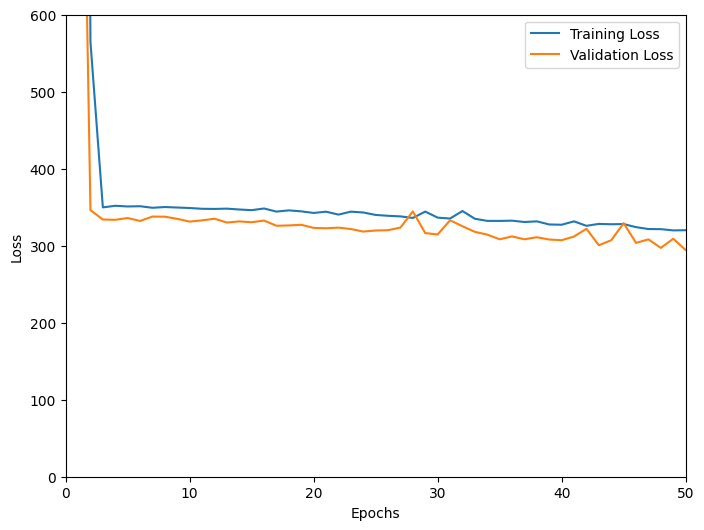

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
#plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.ylim(0,600)
plt.xlim(0,50)

# Display legend
plt.legend()

# Show plot
plt.show()

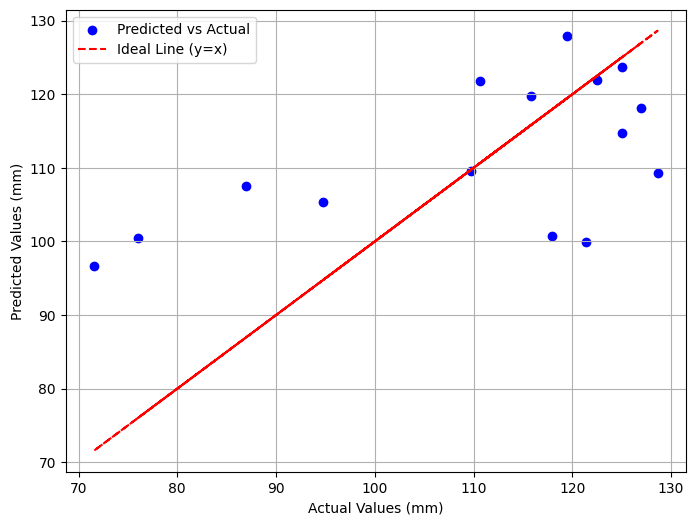

In [ ]:
# Example actual and predicted values
actual_values = y_test
predicted_values = predictions

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Predicted vs Actual')

# Plot a perfect prediction line (y=x)
plt.plot(actual_values, actual_values, color='red', linestyle='dashed', label='Ideal Line (y=x)')

# Labels and title
plt.xlabel("Actual Values (mm)")
plt.ylabel("Predicted Values (mm)")
#plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Uncertainity estimation

## Estimating Uncertainty using Monte Carlo (MC) Dropout

Monte Carlo (MC) Dropout is a simple yet effective way to estimate uncertainty in deep learning models. It works by enabling dropout at inference time and performing multiple forward passes to get a distribution of predictions.

To implement MC Dropout, you need to:

1. Add a Dropout layer in your model.
2. Keep dropout active during inference by using training=True when calling the model.

### Modified Model with Dropout

In [ ]:
class FewShotModel(tf.keras.Model):
    def __init__(self, embedding_dim, dropout_rate=0.2):
        super(FewShotModel, self).__init__()
        self.embedding_layer = layers.Dense(embedding_dim, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)  # MC Dropout layer
        self.regression_head = layers.Dense(1)  # Regression for leaf length prediction

    def call(self, inputs, training=True):
        embeddings = self.embedding_layer(inputs)
        embeddings = self.dropout(embeddings, training=training)  # Keep dropout active
        leaf_length_pred = self.regression_head(embeddings)
        return leaf_length_pred

### Training the model

In [ ]:
embedding_dim = 64
model = FewShotModel(embedding_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
history = model.fit(train_features, y_train, epochs=160, batch_size=8, validation_data=(test_features, y_test))

Epoch 1/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 10945.2207 - val_loss: 6650.7363
Epoch 2/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5255.4937 - val_loss: 1907.9274
Epoch 3/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1436.4521 - val_loss: 419.0233
Epoch 4/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 589.6664 - val_loss: 344.8052
Epoch 5/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 547.6868 - val_loss: 346.5321
Epoch 6/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 616.9765 - val_loss: 349.3903
Epoch 7/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 541.9310 - val_loss: 348.7443
Epoch 8/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 507.2013 - val_loss: 353.9222
Epoch 9/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 470.0390 - val_loss: 338.6678
Epoch 10/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 491.3807 - val_loss: 347.2751
Epoch 11/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 511.8628 - val_loss: 356.8529
Epoch 12/16

### Performing MC Dropout to Estimate Uncertainty

In [ ]:
def monte_carlo_prediction(model, x_input, n_simulations=100):
    """
    Perform Monte Carlo Dropout to estimate uncertainty.

    Args:
        model: Trained FewShotModel with Dropout.
        x_input: Input data for prediction.
        n_simulations: Number of stochastic forward passes.

    Returns:
        mean_pred: Mean prediction.
        std_pred: Standard deviation (uncertainty measure).
    """
    preds = np.array([model(x_input).numpy().flatten() for _ in range(n_simulations)])

    mean_pred = preds.mean(axis=0)  # Average prediction
    std_pred = preds.std(axis=0)  # Standard deviation as uncertainty measure

    print(preds)
    return mean_pred, std_pred

In [ ]:
x_sample = test_features

mean_prediction, uncertainty = monte_carlo_prediction(model, x_sample)

print(f"Predicted Leaf Length: {mean_prediction[0]:.4f}")
print(f"Uncertainty (Std Dev): {uncertainty[0]:.4f}")

[[103.22764  115.87035  104.752174 ... 107.006065  89.72359  123.11817 ]
 [103.56011   99.4206   112.53748  ...  83.631905 113.522896 113.20764 ]
 [121.46671  115.08563   96.43546  ... 101.52336   96.34375  102.8881  ]
 ...
 [113.32609  107.24678   97.9714   ...  92.81284   88.87304  112.006386]
 [111.668945 123.790276  98.25614  ... 101.02749   96.52282  131.88164 ]
 [ 74.21901  123.790276  64.2759   ...  91.35233   95.49204  122.29032 ]]
Predicted Leaf Length: 110.9945
Uncertainty (Std Dev): 14.4457


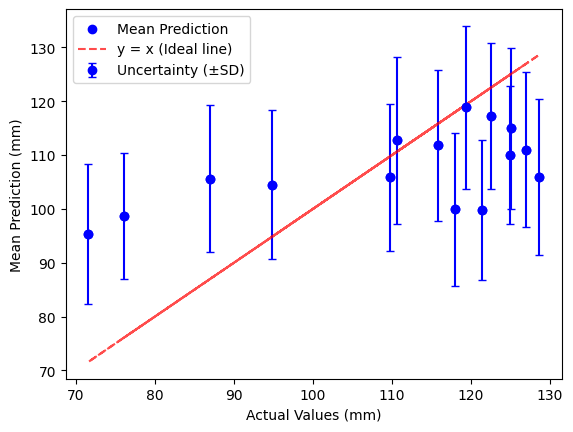

In [ ]:
x = y_test
mean = mean_prediction
std = uncertainty

# Plot mean with error bars (Option 1: Scatter instead of line)
plt.errorbar(x, mean, yerr=std, fmt='o', capsize=3, label="Uncertainty (±SD)", color='blue')
plt.scatter(x, mean, color='blue', label="Mean Prediction")  # Scatter plot instead of connecting line

# Add dashed line for y = x
plt.plot(x, x, linestyle="dashed", color="red", alpha=0.7, label="y = x (Ideal line)")

# Labels and legend
plt.xlabel("Actual Values (mm)")
plt.ylabel("Mean Prediction (mm)")
#plt.title("MC Dropout Uncertainty with Error Bars")
plt.legend()
plt.show()

In [ ]:
pip install uncertainty-toolbox

In [ ]:
import uncertainty_toolbox as uct

<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

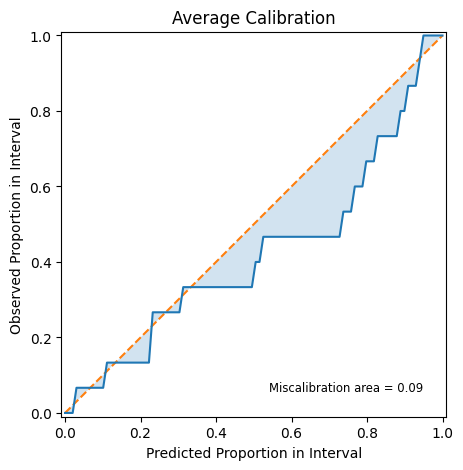

In [ ]:
uct.plot_calibration(mean, std, y_test)

## Estimating uncertainity using Conformal Prediction (CP)

In [ ]:
class FewShotModel(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(FewShotModel, self).__init__()
        self.embedding_layer = layers.Dense(embedding_dim, activation='relu')
        self.regression_head = layers.Dense(1)  # Regression for leaf length prediction

    def call(self, inputs):
        embeddings = self.embedding_layer(inputs)
        leaf_length_pred = self.regression_head(embeddings)
        return leaf_length_pred

##### Instantiate and compile model

In [ ]:
embedding_dim = 64
model = FewShotModel(embedding_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

##### Train model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
history = model.fit(train_features, y_train, epochs=160, batch_size=8, validation_data=(test_features, y_test))

Epoch 1/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10840.0820 - val_loss: 6208.1396
Epoch 2/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4562.1924 - val_loss: 1470.3904
Epoch 3/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 911.9982 - val_loss: 360.0243
Epoch 4/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 372.6931 - val_loss: 335.7415
Epoch 5/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 352.3297 - val_loss: 337.0678
Epoch 6/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 330.9005 - val_loss: 335.9824
Epoch 7/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 404.5106 - val_loss: 332.3417
Epoch 8/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 346.7151 - val_loss: 334.1415
Epoch 9/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 313.2547 - val_loss: 335.7758
Epoch 10/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 360.5220 - val_loss: 337.3651
Epoch 11/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 352.7284 - val_loss: 330.1313
Epoch 12/160
4

##### Conformal prediction

In [ ]:
# Step 1: Compute Nonconformity Scores on the training set
train_predictions = model(train_features).numpy()
nonconformity_scores = np.abs(y_train - train_predictions.flatten())  # Absolute error as the nonconformity score

# Step 2: Sort nonconformity scores
sorted_scores = np.sort(nonconformity_scores)

# Step 3: Define a significance level (for example, 95% confidence)
alpha = 0.05
quantile_index = int((1 - alpha) * len(sorted_scores))

# Step 4: Get the threshold for the prediction interval
threshold = sorted_scores[quantile_index]

# Step 5: Predict for all test samples
y_new_pred = model(test_features).numpy()

lower_bounds = y_new_pred.flatten() - threshold
upper_bounds = y_new_pred.flatten() + threshold

prediction_intervals = list(zip(lower_bounds, upper_bounds))

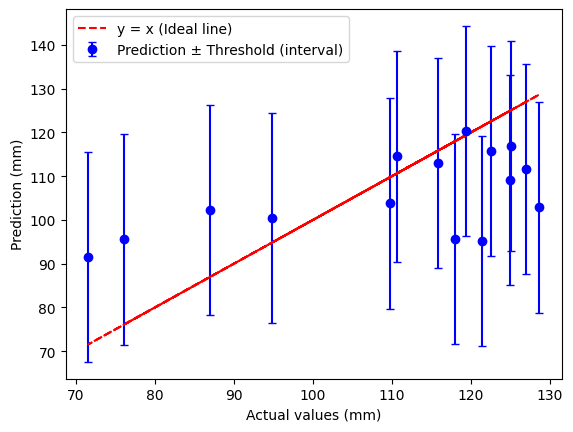

In [ ]:

y_err = threshold  # Since the interval is symmetric

# Create x values for test samples
#x_test = np.arange(len(y_new_pred))  # Index for each test sample

# Plot predictions with error bars
plt.errorbar(y_test, y_new_pred.flatten(), yerr=y_err, fmt='o', capsize=3, label="Prediction ± Threshold (interval)", color='blue')

# Optionally, add a reference line (y = x) for better visualization
plt.plot(y_test, y_test, linestyle='dashed', color='red', label="y = x (Ideal line)")

# Labels and title
plt.xlabel("Actual values (mm)")
plt.ylabel("Prediction (mm)")
#plt.title("Conformal Prediction Intervals")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class FewShotModel(BaseEstimator, RegressorMixin):
    def __init__(self, embedding_dim):
        # Initialize the model
        self.embedding_dim = embedding_dim
        self.model = tf.keras.Sequential([
            layers.Dense(self.embedding_dim, activation='relu'),
            layers.Dense(1)  # Regression head for leaf length prediction
        ])

    def fit(self, X, y):
        # Convert X and y to numpy arrays, if they aren't already
        X = np.array(X)
        y = np.array(y)

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')

        # Fit the model
        self.model.fit(X, y, epochs=160, batch_size=8, verbose=0)

        return self

    def predict(self, X):
        # Predict using the trained model
        X = np.array(X)
        return self.model.predict(X).flatten()

    def score(self, X, y):
        # Return the R^2 score of the model
        X = np.array(X)
        y = np.array(y)
        y_pred = self.predict(X)

        # Compute R^2 score
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)

In [ ]:
pip install mapie

In [ ]:
from mapie.regression import MapieRegressor

In [ ]:
model = FewShotModel(embedding_dim=64)

In [ ]:
mapie_regressor = MapieRegressor(estimator=model, method='naive', cv=5)

In [ ]:
mapie_regressor.fit(train_features, y_train)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


MapieRegressor(cv=5, estimator=FewShotModel(embedding_dim=64), method='naive')

In [ ]:
y_pred, y_pis = mapie_regressor.predict(test_features, alpha=[0.05])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


In [ ]:
y_pis

array([[[ 86.86062714],
        [143.12985138]],

       [[ 70.68689819],
        [126.95612244]],

       [[ 67.089776  ],
        [123.35900024]],

       [[ 95.9030542 ],
        [152.17227844]],

       [[ 90.01072784],
        [146.27995209]],

       [[ 92.16088196],
        [148.4301062 ]],

       [[ 75.41036316],
        [131.6795874 ]],

       [[ 83.55954071],
        [139.82876495]],

       [[ 78.38999268],
        [134.65921692]],

       [[ 90.68343445],
        [146.95265869]],

       [[ 70.42343231],
        [126.69265656]],

       [[ 78.86338898],
        [135.13261322]],

       [[ 70.60329529],
        [126.87251953]],

       [[ 77.19278809],
        [133.46201233]],

       [[ 88.1021051 ],
        [144.37132935]]])

In [ ]:
y_pred

array([114.99524 ,  98.82151 ,  95.22439 , 124.03767 , 118.14534 ,
       120.295494, 103.544975, 111.69415 , 106.524605, 118.81805 ,
        98.558044, 106.998   ,  98.73791 , 105.3274  , 116.23672 ],
      dtype=float32)

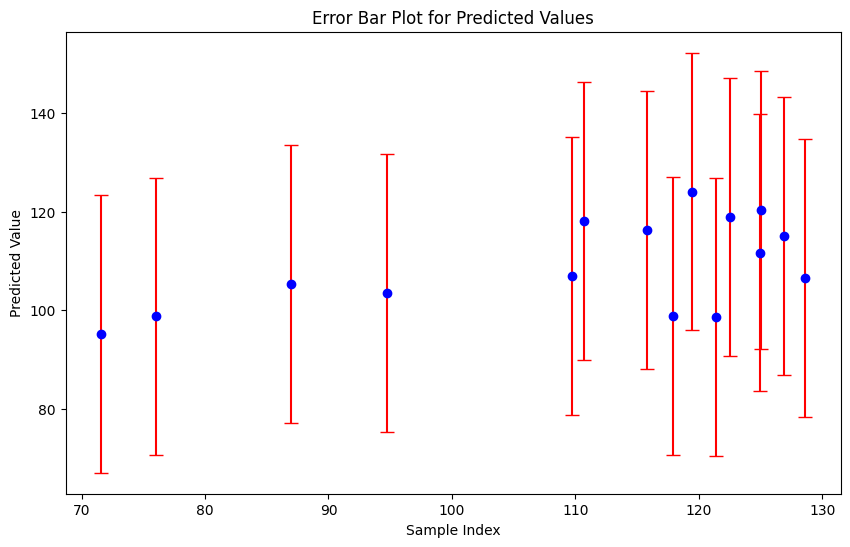

In [ ]:
# Extract lower and upper values
lower_limits = y_pis[:, 0, 0]
upper_limits = y_pis[:, 1, 0]

# Calculate the errors (upper - lower limits)
errors = [y_pred - lower_limits, upper_limits - y_pred]

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(y_test, y_pred, yerr=errors, fmt='o', color='blue', ecolor='red', capsize=5)

plt.plot(y_test, y_test, linestyle='dashed', color='red', label="y = x (Ideal line)")

# Labels and title
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.title('Error Bar Plot for Predicted Values')

# Show the plot
plt.show()

<Axes: title={'center': 'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

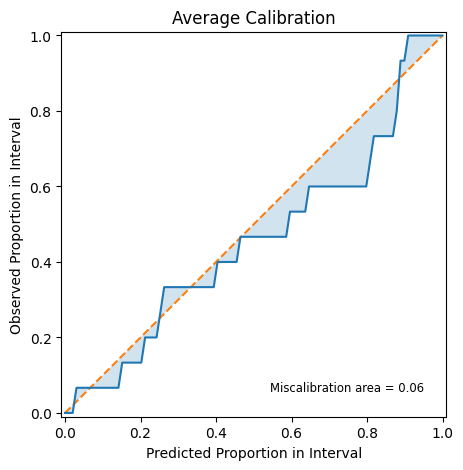

In [ ]:
# Z-score for a 95% confidence interval
Z = 1.96

# Calculate standard deviation
std_2 = (upper_limits - lower_limits) / (2 * Z)

uct.plot_calibration(y_pred, std_2, y_test)